# Objective

The objective of this analysis is verify the conclusion obtained in our previous analysis using the stockel dataset.

# Steps

1. We'll use the microarray expression dataset obtained by Toepel et al; link: https://jb.asm.org/content/190/11/3904
2. We'll select the genes which are part of any two-component system and the circadian clock genes using the genomic annotations of Cyanothece obtained from the studies of Welsh et al; link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2567498/
3. We'll use scikit-learn's mutual information regression to calculate the correlation between the primary and secondary components and also between the clock genes.
4. Using a list of probable sensor-regulator pairs sorted by the mutual information value between them, we can predict which sensor is mostly likely to interact with a regulator and vice versa and also with the clock. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import numpy as np
import multiprocessing as mp
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns

# Data Preprocessing

In [2]:
df_toepel = pd.read_csv('MicroarrayData/ToepelProcessed.csv')

In [3]:
df_toepel.head()

,Contig,ORF,Day1_L2,Day1_L6,Day1_L10,Day1_D2,Day1_D6,Day1_D10,Day2_LL2,Day2_LL6,Day2_LL10,Day2_LD2,Day2_LD6,Day2_LD10
0,Contig0.10_10_14370_15446,cce_4187,0.119984,0.574008,-0.497268,-0.946784,-0.912688,-0.555053,0.389711,0.755742,-0.552432,-0.620710,0.161136,0.618904
1,Contig0.10_11_16336_15422,cce_4186,-0.006948,0.377326,0.281436,0.096787,0.101432,-0.168668,0.030779,0.289256,0.232399,-0.285271,0.064953,0.001840
2,Contig0.10_12_16503_17552,cce_4185,0.334171,-0.366012,0.161679,-0.743794,-0.841029,-0.762609,0.368210,-0.270551,0.121346,0.252908,0.181769,0.212853
3,Contig0.10_13_17679_17981,cce_4184,0.418948,-0.146916,-0.605930,-0.099442,-0.115359,0.130870,0.194944,-0.082366,-0.290507,0.052271,0.094243,0.111787
4,Contig0.10_14_18000_18698,cce_4183,0.324850,0.036866,-0.001216,-0.144987,0.029886,0.111226,0.162255,-0.062873,0.064338,0.090790,0.173198,0.289154


A quick look at the above dataframe will show that there are repeats in the ORF column

In [4]:
len(df_toepel.ORF)==len(set(df_toepel.ORF))

False

We need to find the ORFs that are duplicated.

In [5]:
duplicates = df_toepel.loc[df_toepel.duplicated(subset='ORF',keep=False)].sort_values(by=['ORF'])

In [6]:
duplicates.head()

,Contig,ORF,Day1_L2,Day1_L6,Day1_L10,Day1_D2,Day1_D6,Day1_D10,Day2_LL2,Day2_LL6,Day2_LL10,Day2_LD2,Day2_LD6,Day2_LD10
4089,Contig62.1_1_1274_207,cce_0015,0.358243,-0.130405,-0.188194,-0.260832,0.128074,0.250259,0.330951,-0.166504,0.013392,0.032084,-0.062092,-0.097793
3925,Contig6.1_2_481_873,cce_0015,0.395011,-0.258260,-0.303179,-0.419339,-0.122089,0.180624,0.424158,-0.302026,-0.041410,0.037448,-0.164989,-0.173628
4098,Contig62.2_1_424_44,cce_0027,-0.032668,0.067178,0.198460,-0.063797,-0.132410,0.091539,-0.109167,0.014529,0.125467,-0.069524,0.183824,0.212867
4088,Contig62.1_14_11081_10533,cce_0027,-0.069485,0.150048,0.193104,-0.299913,-0.566255,0.079567,-0.139078,-0.138654,0.194732,-0.063706,0.163336,0.179056
4698,Contig80.1_14_16018_15353,cce_0067,-0.078798,-0.036012,-0.018563,0.115044,0.136906,0.086466,-0.023025,-0.015671,-0.020260,-0.037982,0.069587,0.027299


We'll will take the mean of the expression values of the duplicates.

In [7]:
mean_columns = list(duplicates.columns)
mean_columns.remove('Contig')
mean_columns.remove('ORF')

In [8]:
df_expression = df_toepel.groupby('ORF')[mean_columns].mean().reset_index()

Now we download the Cyanothece Database with genomic annotations. 

In [9]:
GenCyanoDB = pd.read_excel('GenCyanoDB.xlsx',index_col=0,usecols=[0,1,2,3])

In [10]:
GenCyanoDB.head()

,ORF,Function,CommonName
0,cce_0001,hypothetical protein,cce_0001
1,cce_0002,alcohol dehydrogenase,cce_0002
2,cce_0003,hypothetical protein,cce_0003
3,cce_0004,cation efflux system membrane protein,czcA
4,cce_0005,conserved hypothetical protein,cce_0005


First, let's find how many genes have the keyword regulator, two-component, kinase, sensor or circadian in their functional annotation. 

In [11]:
twoComponents = GenCyanoDB[GenCyanoDB['Function'].str.contains("two-component|kinase|regulator|sensor|circadian")]

In [12]:
len(twoComponents),len(twoComponents.loc[twoComponents.ORF.isin(df_toepel.ORF)])

(211, 204)

It's clear from above that we do not have expression profiles for 7 genes. Let's find which ones.

In [13]:
twoComponents.loc[~twoComponents.ORF.isin(df_toepel.ORF)]

,ORF,Function,CommonName
11,cce_0012,two-component response regulator,cce_0012
798,cce_0800,acetate kinase,ackA1
4029,cce_4034,adenylate kinase,adk
4070,cce_4075,putative ATP-NAD/AcoX kinase,cce_4075
4586,cce_4591,guanylate kinase,gmk
4654,cce_4659,two-component response regulator,cce_4659
4710,cce_4715,putative circadian clock protein,kaiB2


We do not have the same 7 genes expression data here as well. 

Next we need to merge the 2 dataframes.

In [14]:
twoComponentsExp = df_expression.merge(twoComponents,on='ORF',how='inner')

First, we will check the length of the dataframe.

In [15]:
assert len(twoComponentsExp)==len(twoComponents.loc[twoComponents.ORF.isin(df_toepel.ORF)])

In [16]:
twoComponentsExp.head()

,ORF,Day1_L2,Day1_L6,Day1_L10,Day1_D2,Day1_D6,Day1_D10,Day2_LL2,Day2_LL6,Day2_LL10,Day2_LD2,Day2_LD6,Day2_LD10,Function,CommonName
0,cce_0016,0.020815,0.025280,0.035900,0.010091,0.106032,0.021714,-0.047783,0.005781,0.025963,-0.010045,0.080937,0.070583,two-component sensor histidine kinase,cce_0016
1,cce_0115,0.297869,0.266111,0.055197,-0.602793,-0.454150,-0.128624,0.084665,0.146252,0.081213,-0.313614,-0.080785,0.040876,response regulator,cce_0115
2,cce_0123,-0.022049,-0.025439,-0.181873,0.103217,0.331547,0.159714,-0.036170,-0.051452,-0.372445,0.032771,0.074082,0.339362,thiamine monophosphate kinase,thiL
3,cce_0145,0.290729,-0.048554,-0.441629,-0.067762,-0.256788,0.030223,0.144654,-0.331048,-0.321781,-0.254037,-0.458068,-0.559191,putative circadian clock protein,kaiB4
4,cce_0164,0.192083,0.083880,-0.161234,-0.223011,-0.179374,0.195019,0.058844,-0.029044,0.066837,-0.054009,-0.024873,-0.001319,two-component sensor histidine kinase,cce_0164


# Mutual Information Calculation

Next we need to develop a ranked list of the interactions between the genes of the twoCompenentsExp dataframe with each other. We hope to find a primary component with a high correlation to a secondary component and vice versa. That will help us to conclude that they are a part of the two-component regulation system. As a correlation metric, we will use mutual information since it can capture non-linear interactions. 

In [17]:
class Interaction:
    def __init__(self,Exp_data,gene='all',mi_thresh=0):
        self.Exp_data = Exp_data
        if self.Exp_data.isnull().values.any():
            self.Exp_df = self.Exp_data.iloc[:,:-2].set_index('ORF').interpolate(method='linear',axis=1,limit_direction='both').T
        else:
            self.Exp_df = self.Exp_data.iloc[:,:-2].set_index('ORF').T
        if gene=='all':
            self.mi_dict = self._get_dict()
        else:
            self.gene_orf = gene
            self.mi_list = self._miscorelist(self.gene_orf)
            self.mi_thresh = mi_thresh
            self.df = self._get_df(self.mi_list,self.mi_thresh)
           
    
    def _get_dict(self):
        all_genes = list(self.Exp_df.columns)
        pool = mp.Pool(mp.cpu_count())
        results = pool.map(self._miscorelist,all_genes)
        fast_dict= dict(zip(all_genes,results))
        return fast_dict

    
    def _miscorelist(self,gene):
        all_other_genes_df = self.Exp_df.loc[:,self.Exp_df.columns!=gene]
        all_other_genes = np.array(all_other_genes_df.columns)
        this_gene_df = self.Exp_df[gene]
        mi_score = mutual_info_regression(all_other_genes_df,this_gene_df,discrete_features=False,random_state=7)
        miscore_genes = list(zip(all_other_genes,mi_score))
        sorted_miscore = sorted(miscore_genes,key = lambda x:x[1],reverse=True)
        return sorted_miscore
    
    def _get_df(self,mi_list,mi_thresh):
        my_dict = {'orf':[],'function':[],'CommonName':[],'mi':[]}
        for orf,mi in mi_list:
            if mi<=mi_thresh:
                break

            my_dict['orf'].append(orf)
            my_dict['function'].append(twoComponentsExp.loc[twoComponentsExp.ORF==orf].Function.values[0])
            my_dict['CommonName'].append(twoComponentsExp.loc[twoComponentsExp.ORF==orf].CommonName.values[0])
            my_dict['mi'].append(mi)

        return pd.DataFrame(my_dict)
    
    def get_twoComponentHybrids(self):
        return self.df.loc[self.df.function.str.contains('two-component') & self.df.function.str.contains('hybrid')]
    
    def get_twoComponentSensors(self):
        return self.df.loc[self.df.function.str.contains('two-component') & self.df.function.str.contains('sensor') & ~self.df.function.str.contains('hybrid')]
    
    def get_twoComponentRegulators(self):
        return self.df.loc[self.df.function.str.contains('two-component') & self.df.function.str.contains('regulator') & ~self.df.function.str.contains('hybrid')]

    def get_other_clock(self):
        return self.df.loc[self.df.function.str.contains('clock protein')]

# Cyanothece clock genes interaction

In [18]:
clock_genes = {i:GenCyanoDB.loc[GenCyanoDB.CommonName==i].ORF.values[0] for i in ['kaiA','kaiB1','kaiB3',
                                                                                  'kaiB4','kaiC1','kaiC2']}

## KaiA

In [19]:
kA = Interaction(twoComponentsExp,clock_genes['kaiA'],mi_thresh=0)

## KaiB1

In [20]:
kB1 = Interaction(twoComponentsExp,clock_genes['kaiB1'],mi_thresh=0)

## KaiB3

In [21]:
kB3 = Interaction(twoComponentsExp,clock_genes['kaiB3'],mi_thresh=0)

## KaiB4

In [22]:
kB4 = Interaction(twoComponentsExp,clock_genes['kaiB4'],mi_thresh=0)

## KaiC1

In [23]:
kC1 = Interaction(twoComponentsExp,clock_genes['kaiC1'],mi_thresh=0)

## KaiC2

In [24]:
kC2 = Interaction(twoComponentsExp,clock_genes['kaiC2'],mi_thresh=0)

In [25]:
clock_interaction_dict = {'kaiA':kA,'kaiB1':kB1,'kaiB3':kB3,'kaiB4':kB4,'kaiC1':kC1,'kaiC2':kC2}

# MI visualization

In [26]:
class ClockVisualize:
    def __init__(self,dictionary_of_interactions,interaction_type='sensor'):
        if not all(list(map(self._verify_interaction,dictionary_of_interactions.values()))):
            raise ValueError('Objects are not valid instances of class type Interaction')

        else:
            self.interaction_type=interaction_type
            self.clock_genes = list(dictionary_of_interactions.keys())
            self.interactions = list(dictionary_of_interactions.values())
            self.k_matrix,self.tc_dict,self.clock_dict = self._get_matrix()
    
    def _verify_interaction(self,obj):
        return isinstance(obj,Interaction)
    
    def _get_info_clock(self,interaction_obj):
        return interaction_obj.get_other_clock()
    
    def _get_info_sensors(self,interaction_obj):
        return interaction_obj.get_twoComponentSensors()
            
    def _get_info_regulators(self,interaction_obj):
        return interaction_obj.get_twoComponentRegulators()
        
    def _get_info_hybrids(self,interaction_obj):
        return interaction_obj.get_twoComponentHybrids()
    
    def _get_common_names(self,info):
        return info.CommonName.values
    
    def _get_mi(self,info,common_name):
        return info.loc[info.CommonName==common_name].mi.values[0]
        
 
    def _get_matrix(self):
        function_dict = {'sensor':self._get_info_sensors,'regulator':self._get_info_regulators,
                         'hybrid':self._get_info_hybrids,'clock':self._get_info_clock}
        _info_list = list(map(function_dict[self.interaction_type],self.interactions))
        _common_names = list(map(self._get_common_names,_info_list))
        _all = np.concatenate((_common_names),axis=None)
        _set = sorted(set(_all))
        _set_cn_dict = dict(zip(_set,range(len(_set))))
        clock_genes_cn_dict = dict(zip(self.clock_genes,range(len(self.clock_genes))))
        k_matrix = np.zeros((len(clock_genes_cn_dict),len(_set_cn_dict)))
        for i,_info in enumerate(_info_list):
            clock_gene_name = self.clock_genes[i]
            for j in _info.CommonName.values:
                k_matrix[clock_genes_cn_dict[clock_gene_name]][_set_cn_dict[j]] = self._get_mi(_info,j)
        return k_matrix,_set_cn_dict,clock_genes_cn_dict



    def visualize_matrix(self):
        
        plt.figure(figsize=(12,10/26*self.k_matrix.shape[1]))
        sns.heatmap(self.k_matrix.T,yticklabels=self.tc_dict.keys(),
                    xticklabels=self.clock_dict.keys(),annot=True,linewidths=0.5)
        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = plt.ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        plt.ylim(b, t) # update the ylim(bottom, top) values
        plt.title('Correlation Matrix')
        plt.xlabel('Kai Genes')
        last_term = {'sensor':'Two Component Sensors','regulator':'Two Component Regulators',
                     'hybrid':'Two Component Hybrids','clock':'Kai Genes'}
        plt.ylabel(last_term[self.interaction_type])
        plt.show() # ta-da!
        

# Visualizing the iteractions 

## Visualizing the interaction between the Cyanothece clock genes

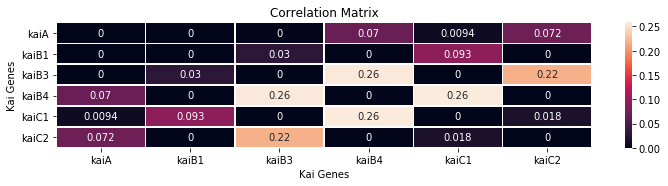

In [27]:
clock = ClockVisualize(clock_interaction_dict,
                        interaction_type='clock')

clock.visualize_matrix()

## Visualizing the sensors and regulators that interact with any clock gene.

### Sensors

In [28]:
sensor = ClockVisualize(clock_interaction_dict,
                        interaction_type='sensor')

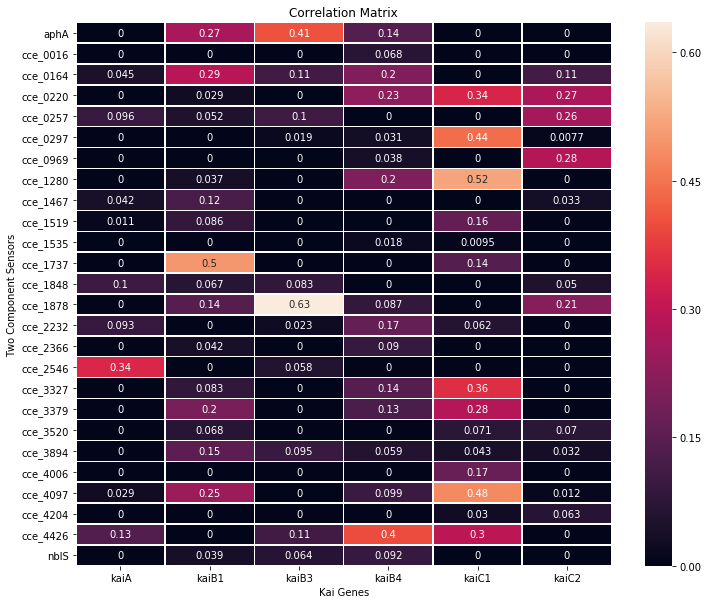

In [29]:
sensor.visualize_matrix()

### Regulators

In [30]:
regulator = ClockVisualize(clock_interaction_dict,
                        interaction_type='regulator')

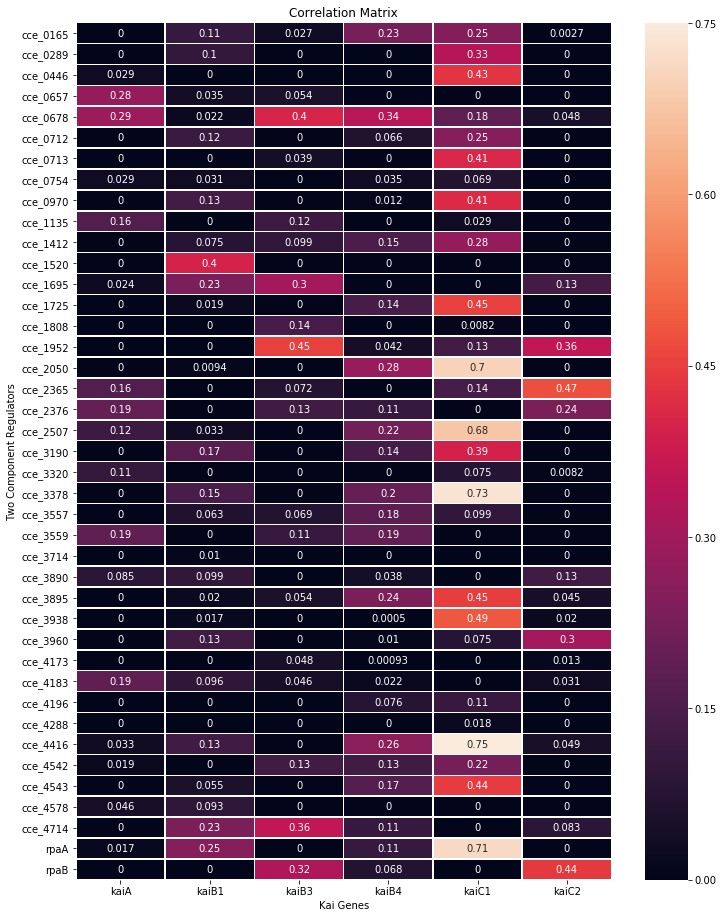

In [31]:
regulator.visualize_matrix()

### Hybrids

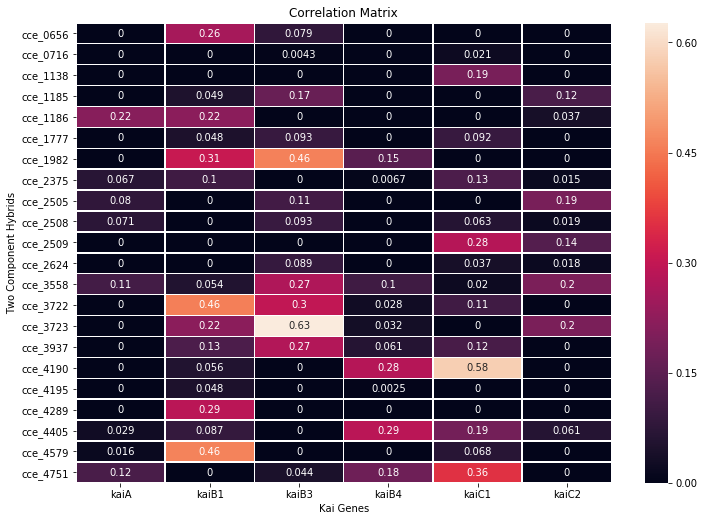

In [32]:
hybrid = ClockVisualize(clock_interaction_dict,
                        interaction_type='hybrid')

hybrid.visualize_matrix()

# Finding the most common sensors and regulators that interact with all the clock genes

## Sensors

In [33]:
def get_sensor_names(interaction_obj):
    return interaction_obj.get_twoComponentSensors().CommonName.values

In [34]:
sensors = list(map(get_sensor_names,clock_interaction_dict.values()))

def most_common_elements(given_set):
    main_set = set(given_set[0])

    for sarray in given_set[1:]:
        sset = set(sarray)
        main_set.intersection_update(sset)
    return main_set

In [35]:
twoComponentsExp.loc[twoComponentsExp.ORF.isin(most_common_elements(sensors))]

,ORF,Day1_L2,Day1_L6,Day1_L10,Day1_D2,Day1_D6,Day1_D10,Day2_LL2,Day2_LL6,Day2_LL10,Day2_LD2,Day2_LD6,Day2_LD10,Function,CommonName


## Regulators

In [36]:
def get_regulator_names(interaction_obj):
    return interaction_obj.get_twoComponentRegulators().CommonName.values

In [37]:
regulators = list(map(get_regulator_names,clock_interaction_dict.values()))

In [38]:
twoComponentsExp.loc[twoComponentsExp.ORF.isin(most_common_elements(regulators))]

,ORF,Day1_L2,Day1_L6,Day1_L10,Day1_D2,Day1_D6,Day1_D10,Day2_LL2,Day2_LL6,Day2_LL10,Day2_LD2,Day2_LD6,Day2_LD10,Function,CommonName
28,cce_0678,0.729695,-0.004934,-0.347867,-1.221355,-0.678034,-0.012713,0.576448,-0.210719,-0.430487,-0.013558,-0.146894,-0.110686,two-component response regulator,cce_0678


# Finding the kaiA,kaiB,kaiC combination that interacts with the maximum number of sensors and regulators

In [39]:
from itertools import product
clock_gene_copies = list(clock_genes.keys())
kaiA_copies = clock_gene_copies[0:1]
kaiB_copies = clock_gene_copies[1:4]
kaiC_copies = clock_gene_copies[4:]
print(list(product(kaiA_copies,kaiB_copies,kaiC_copies)))

[('kaiA', 'kaiB1', 'kaiC1'), ('kaiA', 'kaiB1', 'kaiC2'), ('kaiA', 'kaiB3', 'kaiC1'), ('kaiA', 'kaiB3', 'kaiC2'), ('kaiA', 'kaiB4', 'kaiC1'), ('kaiA', 'kaiB4', 'kaiC2')]


In [40]:
clock_gene_sensors = dict(zip(clock_gene_copies,sensors))
clock_gene_regulators = dict(zip(clock_gene_copies,regulators))

number_dict = {}

for a,b,c in product(kaiA_copies,kaiB_copies,kaiC_copies):
    sensors_list = [clock_gene_sensors[i] for i in (a,b,c)]
    regulators_list = [clock_gene_regulators[i] for i in (a,b,c)]
    sensor_len = len(twoComponentsExp.loc[twoComponentsExp.CommonName.isin(most_common_elements(sensors_list))])
    regulator_len = len(twoComponentsExp.loc[twoComponentsExp.CommonName.isin(most_common_elements(regulators_list))])
    total_len = sensor_len+regulator_len
    number_dict[(a,b,c)] = [sensor_len,regulator_len,total_len]
    
{k:v for k,v in sorted(number_dict.items(),key=lambda x: x[1][2],reverse=True)}

{('kaiA', 'kaiB1', 'kaiC2'): [5, 5, 10],
 ('kaiA', 'kaiB4', 'kaiC1'): [3, 6, 9],
 ('kaiA', 'kaiB3', 'kaiC2'): [3, 5, 8],
 ('kaiA', 'kaiB1', 'kaiC1'): [2, 5, 7],
 ('kaiA', 'kaiB4', 'kaiC2'): [2, 5, 7],
 ('kaiA', 'kaiB3', 'kaiC1'): [2, 4, 6]}

# Case Studies of some interesting genes that were found in the last report

## cce_0678 case study

In [41]:
cce_0678 = Interaction(twoComponentsExp,'cce_0678',mi_thresh=0)
cce_0678.get_twoComponentSensors()

,orf,function,CommonName,mi
6,cce_0164,two-component sensor histidine kinase,cce_0164,0.398052
19,cce_4426,two-component sensor histidine kinase,cce_4426,0.242130
25,cce_1280,two-component sensor histidine kinase,cce_1280,0.224904
45,cce_2232,two-component sensor histidine kinase,cce_2232,0.192331
48,cce_0220,two-component sensor histidine kinase,cce_0220,0.188958
55,cce_1983,"probable phytochrome A, two-component sensor p...",aphA,0.171895
56,cce_2546,probable two-component sensor histidine kinase,cce_2546,0.164090
81,cce_1878,two-component sensor histidine kinase,cce_1878,0.128905
83,cce_1535,two-component sensor histidine kinase,cce_1535,0.125863
85,cce_0888,two-component sensor histidine kinase,nblS,0.120969


## rpaA case study

In [42]:
cce_0298 = Interaction(twoComponentsExp,'cce_0298',mi_thresh=0)
cce_0298.get_twoComponentSensors()

,orf,function,CommonName,mi
11,cce_4097,two-component sensor serine/threonine kinase,cce_4097,0.523945
17,cce_0220,two-component sensor histidine kinase,cce_0220,0.444084
18,cce_1280,two-component sensor histidine kinase,cce_1280,0.427351
19,cce_0297,two-component sensor histidine kinase,cce_0297,0.425929
27,cce_3379,two-component sensor histidine kinase,cce_3379,0.391207
30,cce_4426,two-component sensor histidine kinase,cce_4426,0.345770
48,cce_3327,two-component sensor histidine kinase,cce_3327,0.229004
64,cce_1519,two-component sensor histidine kinase,cce_1519,0.165512
102,cce_2546,probable two-component sensor histidine kinase,cce_2546,0.086544
103,cce_4204,two-component sensor histidine kinase,cce_4204,0.085351


## sasA case study

In [43]:
cce_1751 = Interaction(twoComponentsExp,'cce_1751',mi_thresh=0)
cce_1751.get_twoComponentRegulators()

,orf,function,CommonName,mi
3,cce_1952,two-component response regulator receiver protein,cce_1952,0.466670
11,cce_4002,two-component response regulator,rpaB,0.369447
12,cce_0712,two-component response regulator,cce_0712,0.339289
15,cce_4578,two-component response regulator,cce_4578,0.291141
19,cce_4714,"two-component response regulator, NarL subfamily",cce_4714,0.275003
38,cce_2376,two-component response regulator,cce_2376,0.168753
42,cce_1695,two-component response regulator,cce_1695,0.154762
48,cce_2365,two-component response regulator,cce_2365,0.127119
57,cce_3895,two-component response regulator,cce_3895,0.097060
58,cce_3714,putative two-component system response regulator,cce_3714,0.094877


## rpaB case study

In [44]:
cce_4002 = Interaction(twoComponentsExp,'cce_4002',mi_thresh=0)
cce_4002.df.head(10)

,orf,function,CommonName,mi
0,cce_1775,nitrogen regulatory protein P-II,glnB,0.500830
1,cce_3901,putative serine/threonine protein kinase,cce_3901,0.476028
2,cce_4716,circadian clock protein,kaiC2,0.440840
3,cce_3420,pyruvate kinase,pykF1,0.434361
4,cce_1878,two-component sensor histidine kinase,cce_1878,0.426623
5,cce_4714,"two-component response regulator, NarL subfamily",cce_4714,0.384725
6,cce_1751,adaptive-response sensory histidine kinase,sasA,0.369447
7,cce_0921,ribose-phosphate pyrophosphokinase,prsA,0.368488
8,cce_2505,two-component hybrid sensor and regulator,cce_2505,0.368191
9,cce_3723,two-component hybrid sensor and regulator,cce_3723,0.344679


# Verifying Previous Conclusions

1. *cce_1983/aphA might be a photoreceptor that regulates the clock genes and the other TFs.* - Seen here as well.
2. *cce_0888/nblS is another interesting component that interacts with the clock genes. In 7942, it is shown to be a gene involved in photosynthesis related gene expression during high light and nutrient stress.* - Seen here as well.
3. *In the previous literature review study report, cce_0678 was proposed to interact with the RubisCo genes. In this study, it was shown that there is a very high mutual information score between cce_0678 and the probable photoreceptor aphA discussed above. This further highlights it's importance as a regulator.* - Seen here as well.
4. *rpaA and rpaB are equally important in cyanothece signaling network according to this analysis. - Seen here as well.*
5. *sasA may not be the kinase that interacts with rpaA in cyanothece. On the otherhand, rpaB may be the regulator that interacts with sasA.* - Seen here as well. 
6. *The KaiB copies may be present not just to maintain robustness but they may play important roles in the signaling network.* - Seen here as well.

# New Conclusions

1. We are missing some interactions because of the frequency of data collection in each case. We need more frequent data. Otherwise we cannot postulate newer interactions. At this moment our analysis is extremely biased towards those interactions which have already been captured in other cyanobacteria like 7942 or nostoc. 
2. The interaction of the clock genes are not the same and extremely erratic. We need more frequent data to conclude anything about the clock genes. However, it is clear that the clock gene copies are present not just to maintain robustness.